In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openai

In [42]:
# get outputs
fp = 'validation_responses.jsonl'
response = []

with open(fp, 'r') as file:
    for line in file:
        line = json.loads(line)
        response.append({'id': line.get('question_id', None), 'output': line.get('text', None)})


In [43]:
# get corresponding image_id from question file
fp = 'question_prompt.jsonl'
input = []

with open(fp, 'r') as file:
    for line in file:
        line = json.loads(line)
        input.append({'id': line.get('question_id', None), 'image_id': line.get('image', None)})

In [44]:
# merge so that we have the corresponding image id for every output
response_df = pd.DataFrame(response)
input_df = pd.DataFrame(input)
df = pd.merge(input_df, response_df, on='id')
df.drop(columns=['id'], inplace=True)
df['image_id'] = df['image_id'].str.replace('.jpg', '')
df

,image_id,output
0,Jemefon_51549626,
1,Rokiemed_51388893,no definite acute abnormality.
2,Hayuxrit_52803982,
3,Phathuro_51403270,no definite acute abnormality.
4,Okorued_52838506,no definite acute abnormality.
...,...,...
2238,Trosoode_52844342,
2239,Opirnag_52893284,no definite acute abnormality.
2240,Shokuja_50802617,
2241,Perpopul_50364068,no definite acute abnormality.


In [45]:
# parse validation data json to get correct labels
fp = 'val_10.json'
labels = []

with open(fp, 'r') as file:
    data = json.load(file)
    for entry in data:
        for convo in entry['conversations']:
            if convo['from'] == 'gpt':
                value = convo['value'] #.replace('<image>\n', '')
        labels.append({'id': entry['id'], 'label': value})


In [46]:
# merge all 
labels_df = pd.DataFrame(labels)
df = pd.merge(labels_df, df, left_on='id', right_on='image_id')
df.drop(columns=['id'], inplace=True)
df

,label,image_id,output
0,<image>\niption: x-ray chest frontal and la...,Jemefon_51549626,
1,<image>\nno acute findings.,Rokiemed_51388893,no definite acute abnormality.
2,<image>\ncardiomegaly with moderate interstiti...,Hayuxrit_52803982,
3,<image>\nmild left basilar opacity in setting ...,Phathuro_51403270,no definite acute abnormality.
4,<image>\nno acute cardiopulmonary or osseous a...,Okorued_52838506,no definite acute abnormality.
...,...,...,...
2238,<image>\nenlarged cardiac silhouette with inte...,Trosoode_52844342,
2239,<image>\nno acute cardiopulmonary abnormality....,Opirnag_52893284,no definite acute abnormality.
2240,<image>\nno acute cardiopulmonary findings and...,Shokuja_50802617,
2241,<image>\nno radiographic evidence of acute car...,Perpopul_50364068,no definite acute abnormality.


In [47]:
# clean up label class
df['label'] = df['label'].str[8:]
df

,label,image_id,output
0,iption: x-ray chest frontal and lateral cl...,Jemefon_51549626,
1,no acute findings.,Rokiemed_51388893,no definite acute abnormality.
2,cardiomegaly with moderate interstitial edema.,Hayuxrit_52803982,
3,mild left basilar opacity in setting of decrea...,Phathuro_51403270,no definite acute abnormality.
4,no acute cardiopulmonary or osseous abnormality.,Okorued_52838506,no definite acute abnormality.
...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,Trosoode_52844342,
2239,no acute cardiopulmonary abnormality. previous...,Opirnag_52893284,no definite acute abnormality.
2240,no acute cardiopulmonary findings and no convi...,Shokuja_50802617,
2241,no radiographic evidence of acute cardiopulmon...,Perpopul_50364068,no definite acute abnormality.


In [48]:
# df.to_csv('label_output.csv', index=False)
print(df.loc[10, 'label'])

frontal view is essentially nondiagnostic due to technique. the cardiac silhouette appears mildly enlarged. the lateral view shows no gross consolidation or overt pulmonary edema. however, consider repeat study for further evaluation.


### Benchmark

In [49]:
# performance looks poor for pneumothorax especially, may need to tune the prompt so that it mentions all disease entities even if they're not found
print(df['label'].str.contains('edema').sum())
print(df['output'].str.contains('edema').sum())
print(df['label'].str.contains('pneumonia').sum())
print(df['output'].str.contains('pneumonia').sum())
print(df['label'].str.contains('pneumothorax').sum())
print(df['output'].str.contains('pneumothorax').sum())

704
18
301
309
218
1


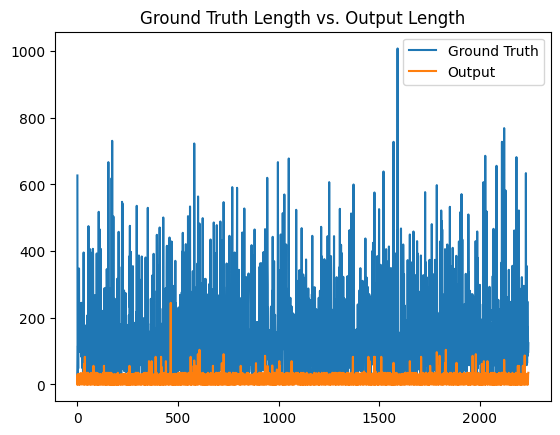

In [101]:
output_len = df['output'].str.len().to_numpy()
label_len = df['label'].str.len().to_numpy()

plt.title('Ground Truth Length vs. Output Length')
plt.plot(label_len, label='Ground Truth')
plt.plot(output_len, label='Output')
plt.legend()

In [ ]:
# for entry in data:
#     radiologist_reading = entry['radiologist_reading']
#     model_output = entry['model_output']
    
#     # Compute semantic similarity
#     similarity_score = compute_similarity(radiologist_reading, model_output)
    
#     # QA or summarization task
#     qa_score = perform_qa_task(radiologist_reading, model_output)
    
#     # Store or process the comparison scores
#     results.append({
#         "entry_id": entry['id'],
#         "similarity_score": similarity_score,
#         "qa_score": qa_score,
#         # Any other metrics or comparison results
#     })

# Process the results (e.g., average scores, statistical analysis)

# def compute_similarity(text1, text2):
#     # Use the LLM to compute embeddings and calculate similarity
#     pass

# def perform_qa_task(question, context):
#     # Use the LLM for QA tasks
#     pass

# # Save or analyze the results
# save_results("comparison_results.json", results)

#### Disease Classification
Use chatgpt to parse both ground truth and output into individual disease classes (no, mild, severe) and then compare.


Disease classes: pneumonia, pulmonary edema, pneumothorax

In [116]:
# for getting response from chatgpt
# def get_completion(prompt, client_instance, model='gpt-3.5-turbo'):
#     messages = [{'role': 'user', 'content': prompt}]
#     response = client_instance.chat.completions.create(
#     model=model,
#     messages=messages,
#     max_tokens=20,
#     temperature=0.2,
#     )
#     return response.choices[0].message.content

# classify all disease classes for each report
def classify_disease(report):
    diseases = {'pneumonia': '', 'pulmonary edema': '', 'pneumothorax': ''}
    for disease in diseases.keys():
        prompt = f"Given this x-ray report: '{report}, determine the severity of {disease} as 'no', 'mild', 'severe'."
        
        diseases[disease] = get_completion(prompt, client)

    return diseases


In [135]:
# from openai import OpenAI
# openai.api_key = ''
# client = OpenAI()

# for i in df.index:
#     label_classes = classify_disease(df.loc[i, 'label'])
#     output_classes = classify_disease(df.loc[i, 'output'])

# testing
# from openai import OpenAI
# client = OpenAI(api_key='')

# completion = client.chat.completions.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
#     {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
#   ]
# )

# print(completion.choices[0].message)

#### Edema

In [21]:
pd.read_csv('label_output_copy.csv')

,label,image_id,output
0,iption: x-ray chest frontal and lateral cl...,Jemefon_51549626,NaN
1,no acute findings.,Rokiemed_51388893,no definite acute abnormality.
2,cardiomegaly with moderate interstitial edema.,Hayuxrit_52803982,NaN
3,mild left basilar opacity in setting of decrea...,Phathuro_51403270,no definite acute abnormality.
4,no acute cardiopulmonary or osseous abnormality.,Okorued_52838506,no definite acute abnormality.
...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,Trosoode_52844342,NaN
2239,no acute cardiopulmonary abnormality. previous...,Opirnag_52893284,no definite acute abnormality.
2240,no acute cardiopulmonary findings and no convi...,Shokuja_50802617,NaN
2241,no radiographic evidence of acute cardiopulmon...,Perpopul_50364068,no definite acute abnormality.


In [18]:
edema = pd.read_csv('gpt_edema.csv')
edema

,label,image_id,output,label_edema,output_edema
0,iption: x-ray chest frontal and lateral cl...,Jemefon_51549626,NaN,No Edema,Not Applicable
1,no acute findings.,Rokiemed_51388893,no definite acute abnormality.,No Edema,No Edema
2,cardiomegaly with moderate interstitial edema.,Hayuxrit_52803982,NaN,Unspecified Edema,Not Applicable
3,mild left basilar opacity in setting of decrea...,Phathuro_51403270,no definite acute abnormality.,No Edema,No Edema
4,no acute cardiopulmonary or osseous abnormality.,Okorued_52838506,no definite acute abnormality.,No Edema,No Edema
...,...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,Trosoode_52844342,NaN,Unspecified Edema,Not Applicable
2239,no acute cardiopulmonary abnormality. previous...,Opirnag_52893284,no definite acute abnormality.,No Edema,No Edema
2240,no acute cardiopulmonary findings and no convi...,Shokuja_50802617,NaN,Unspecified Edema,Not Applicable
2241,no radiographic evidence of acute cardiopulmon...,Perpopul_50364068,no definite acute abnormality.,No Edema,No Edema


In [19]:
edema['label_edema'].value_counts()

label_edema
No Edema             1539
Unspecified Edema     377
Mild Edema            322
Severe Edema            5
Name: count, dtype: int64

In [20]:
edema['output_edema'].value_counts()

output_edema
No Edema             1213
Not Applicable       1012
Unspecified Edema      17
Mild Edema              1
Name: count, dtype: int64

In [21]:
edema.loc[edema['output_edema'] == 'Not Applicable', 'output_edema'] = 'NA'
edema['output_edema'].value_counts()

output_edema
No Edema             1213
NA                   1012
Unspecified Edema      17
Mild Edema              1
Name: count, dtype: int64

In [22]:
edema.loc[edema['label_edema'] == 'Unspecified Edema', 'label_edema'] = 'NA'
edema['label_edema'].value_counts()

label_edema
No Edema        1539
NA               377
Mild Edema       322
Severe Edema       5
Name: count, dtype: int64

In [17]:
edema_accuracy = (edema['label_edema'] == edema['output_edema']).sum() / edema.shape[0]
print('Edema accuracy: ', edema_accuracy)

Edema accuracy:  0.4587605884975479


#### Pneumonia

In [26]:
pneumonia = pd.read_csv('gpt_pneumonia.csv')
pneumonia

,label,output,label_condition,output_condition
0,iption: x-ray chest frontal and lateral cl...,NaN,No,Unknown
1,no acute findings.,no definite acute abnormality.,No,No
2,cardiomegaly with moderate interstitial edema.,NaN,Not Specified,Unknown
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Not Specified,No
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,No,No
...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Not Specified,Unknown
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,No,No
2240,no acute cardiopulmonary findings and no convi...,NaN,No,Unknown
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,No,No


In [29]:
pneumonia['label_condition'].value_counts()

label_condition
No               1291
Not Specified     880
Mild               68
Severe              4
Name: count, dtype: int64

In [30]:
pneumonia['output_condition'].value_counts()

output_condition
Unknown          1012
No                704
Not Specified     527
Name: count, dtype: int64

In [31]:
pneumonia_accuracy = (pneumonia['label_condition'] == pneumonia['output_condition']).sum() / pneumonia.shape[0]
print('Pneumonia accuracy: ', pneumonia_accuracy)

Pneumonia accuracy:  0.3004904146232724


#### pneumothorax

In [50]:
pneumonia['label'].str.contains('pneumothorax').sum()

218

In [35]:
pneumothorax = pd.read_csv('gpt_pneumothorax.csv')
pneumothorax

,label,output,label_pneumothorax_condition,output_pneumothorax_condition
0,iption: x-ray chest frontal and lateral cl...,NaN,Not Specified,Unknown
1,no acute findings.,no definite acute abnormality.,No,No
2,cardiomegaly with moderate interstitial edema.,NaN,Not Specified,Unknown
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Not Specified,No
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,No,No
...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Not Specified,Unknown
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,No,No
2240,no acute cardiopulmonary findings and no convi...,NaN,No,Unknown
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,No,No


In [36]:
pneumothorax['label_pneumothorax_condition'].value_counts()

label_pneumothorax_condition
No               1242
Not Specified     943
Mild               55
Severe              3
Name: count, dtype: int64

In [38]:
pneumothorax.loc[pneumothorax['output_pneumothorax_condition'] == 'Unknown', 'output_pneumothorax_condition'] = 'Not Specified'
pneumothorax['output_pneumothorax_condition'].value_counts()

output_pneumothorax_condition
Not Specified    1231
No               1012
Name: count, dtype: int64

In [39]:

pneumothorax_accuracy = (pneumothorax['label_pneumothorax_condition'] == pneumothorax['output_pneumothorax_condition']).sum() / pneumothorax.shape[0]
print('Pneumothorax accuracy: ', pneumothorax_accuracy)

Pneumothorax accuracy:  0.5158270173874275


##### Main Problems:
- Generated responses are too short, commenting on only one disease
- Generated responses only mention diseases that the patient has, do not note whether or not the patient has the other diseases or the report simply doesn't comment on those. Also don't note the severity of diseases detected --> need to adjust the prompt to ask for it more specifically